In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd '/content/gdrive/MyDrive/RNN'
! ls

/content/gdrive/MyDrive/RNN
10-regression-algorithm.ipynb  Ex_2b.csv
Ex_1.csv		       recurrent-neural-networks-lstm-gru.ipynb
Ex_2a.csv		       USA_Housing.csv


In [3]:
# Importing the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

In [4]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real crack length (mm)')
    plt.plot(predicted, color='blue',label='Predicted crack length (mm)')
    plt.title('Crack length prediction (mm)')
    plt.xlabel('Cycle')
    plt.ylabel('Length (mm)')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

**Prepare data**

In [5]:
# First, we get the data
dataset = pd.read_csv('../RNN/Ex_2b.csv', index_col='Cycle', parse_dates=['Cycle'])
dataset.head()

,Length (mm)
Cycle,
5000,0.830200
5050,0.830916
5100,0.831666
5150,0.832450
5200,0.833269


In [6]:
# Checking for missing values
training_set = dataset[:2100].iloc[:,0:1].values
test_set = dataset[2100:].iloc[:,0:1].values

print('training_set.shape = ', training_set.shape)
print('test_set.shape = ', test_set.shape)

training_set.shape =  (2100, 1)
test_set.shape =  (200, 1)


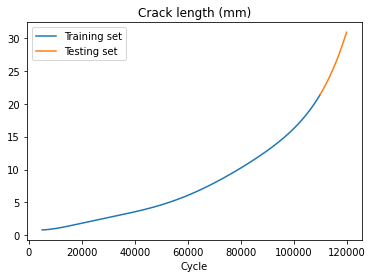

In [7]:
# We have chosen 'Length (mm)' attribute for prices. Let's see what it looks like
dataset["Length (mm)"][:2100].plot(figsize=(6,4),legend=True)
dataset["Length (mm)"][2100:].plot(figsize=(6,4),legend=True)
plt.legend(['Training set','Testing set'])
plt.title('Crack length (mm)')
plt.show()

In [8]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

print('training_set_scaled.shape = ', training_set_scaled.shape)

training_set_scaled.shape =  (2100, 1)


In [9]:
# Since LSTMs store long term memory state, we create a data structure with 50 timesteps and 1 output
# So for each element of training set, we have 50 previous training set elements 
X_train = []
y_train = []
for i in range(50, 2100):
    X_train.append(training_set_scaled[i-50:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)

X_train.shape =  (2050, 50)
y_train.shape =  (2050,)


In [10]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print('X_train.shape = ', X_train.shape)

X_train.shape =  (2050, 50, 1)


**1. LSTM model**

In [11]:
# The LSTM architecture
regressorLSTM = Sequential()

# First LSTM layer with Dropout regularisation
regressorLSTM.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))

# Second LSTM layer
#regressorLSTM.add(LSTM(50, return_sequences=True))
#regressorLSTM.add(Dropout(0.2))

# Third LSTM layer
#regressorLSTM.add(LSTM(50, return_sequences=True))
#regressorLSTM.add(Dropout(0.2))

# Fourth LSTM layer
regressorLSTM.add(LSTM(50))
regressorLSTM.add(Dropout(0.2))

# The output layer
regressorLSTM.add(Dense(1))

regressorLSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compiling the LSTM
regressorLSTM.compile(optimizer='adam', loss='mse')

# Fitting to the training set
lstm = regressorLSTM.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
26/26 [==============================] - 9s 67ms/step - loss: 0.0112 - val_loss: 3.4165e-04
Epoch 2/200
26/26 [==============================] - 1s 30ms/step - loss: 9.2046e-04 - val_loss: 8.2615e-04
Epoch 3/200
26/26 [==============================] - 1s 31ms/step - loss: 6.2314e-04 - val_loss: 1.9712e-04
Epoch 4/200
26/26 [==============================] - 1s 30ms/step - loss: 5.2734e-04 - val_loss: 6.2282e-04
Epoch 5/200
26/26 [==============================] - 1s 31ms/step - loss: 6.0711e-04 - val_loss: 2.8023e-04
Epoch 6/200
26/26 [==============================] - 1s 30ms/step - loss: 5.3955e-04 - val_loss: 3.0460e-05
Epoch 7/200
26/26 [==============================] - 1s 30ms/step - loss: 4.6705e-04 - val_loss: 2.9850e-05
Epoch 8/200
26/26 [==============================] - 1s 30ms/step - loss: 5.3230e-04 - val_loss: 0.0014
Epoch 9/200
26/26 [==============================] - 1s 30ms/step - loss: 5.0635e-04 - val_loss: 3.0198e-05
Epoch 10/200
26/26 [================

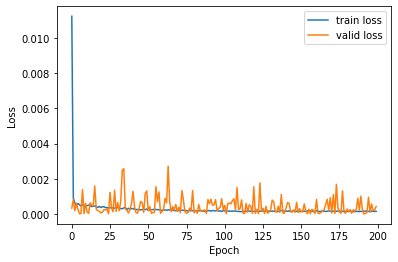

In [13]:
# loss
plt.plot(lstm.history['loss'], label='train loss')
plt.plot(lstm.history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Now to get the testing set ready in a similar way as the training set.
# The following has been done so first 50 entries of test set have 50 previous values which is impossible to get unless we take the whole 
# 'Length (mm)' attribute data for processing
dataset_total = pd.concat((dataset["Length (mm)"][:2100], dataset["Length (mm)"][2100:]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 50:].values
print('dataset_total.shape = ', dataset_total.shape)
print('inputs.shape = ', inputs.shape)

inputs = inputs.reshape(-1,1)
print('inputs.shape = ', inputs.shape)

inputs  = sc.transform(inputs)
print('inputs.shape = ', inputs.shape)

dataset_total.shape =  (2300,)
inputs.shape =  (250,)
inputs.shape =  (250, 1)
inputs.shape =  (250, 1)


In [15]:
# Preparing X_test and predicting the length
X_test = []
for i in range(50, 250):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
print('X_test.shape = ', X_test.shape)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print('X_test.shape = ', X_test.shape)

LSTM_predicted_stock_price = regressorLSTM.predict(X_test)
LSTM_predicted_stock_price = sc.inverse_transform(LSTM_predicted_stock_price)
print('LSTM_predicted_stock_price.shape = ', LSTM_predicted_stock_price.shape)

X_test.shape =  (200, 50)
X_test.shape =  (200, 50, 1)
LSTM_predicted_stock_price.shape =  (200, 1)


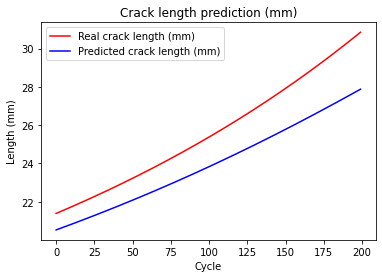

In [16]:
# Visualizing the results for LSTM
plot_predictions(test_set, LSTM_predicted_stock_price)

In [17]:
# Evaluating our model
return_rmse(test_set, LSTM_predicted_stock_price)

The root mean squared error is 1.7713554736673371.


**2. GRU model**

In [18]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
#regressorGRU.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#regressorGRU.add(Dropout(0.2))

# Third GRU layer
#regressorGRU.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(1))

regressorGRU.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           30900     
                                                                 
 dropout_2 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 53,751
Trainable params: 53,751
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer='adam', loss='mse')

# Fitting to the training set
gru = regressorGRU.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
26/26 [==============================] - 5s 67ms/step - loss: 0.0066 - val_loss: 0.0021
Epoch 2/200
26/26 [==============================] - 1s 29ms/step - loss: 9.3014e-04 - val_loss: 8.0223e-04
Epoch 3/200
26/26 [==============================] - 1s 29ms/step - loss: 6.9170e-04 - val_loss: 1.0443e-05
Epoch 4/200
26/26 [==============================] - 1s 29ms/step - loss: 5.9268e-04 - val_loss: 1.9838e-05
Epoch 5/200
26/26 [==============================] - 1s 33ms/step - loss: 6.1494e-04 - val_loss: 1.0666e-04
Epoch 6/200
26/26 [==============================] - 1s 29ms/step - loss: 6.4084e-04 - val_loss: 4.1440e-06
Epoch 7/200
26/26 [==============================] - 1s 37ms/step - loss: 5.9543e-04 - val_loss: 3.3596e-04
Epoch 8/200
26/26 [==============================] - 1s 31ms/step - loss: 5.2171e-04 - val_loss: 2.2877e-04
Epoch 9/200
26/26 [==============================] - 1s 29ms/step - loss: 5.0792e-04 - val_loss: 7.7066e-04
Epoch 10/200
26/26 [================

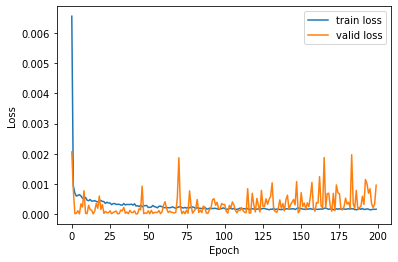

In [20]:
# loss
plt.plot(gru.history['loss'], label='train loss')
plt.plot(gru.history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
# Preparing X_test and predicting the length
X_test = []
for i in range(50, 250):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

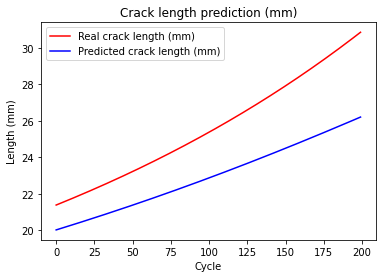

In [22]:
# Visualizing the results for GRU
plot_predictions(test_set, GRU_predicted_stock_price)

In [23]:
# Evaluating GRU
return_rmse(test_set, GRU_predicted_stock_price)

The root mean squared error is 2.8252166472970397.


**3. SimpleRNN model**

In [24]:
# The RNN architecture
regressorRNN = Sequential()

# First RNN layer with Dropout regularisation
regressorRNN.add(SimpleRNN(100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorRNN.add(Dropout(0.2))

# Second RNN layer
#regressorRNN.add(SimpleRNN(50, return_sequences=True))
#regressorRNN.add(Dropout(0.2))

# Third RNN layer
#regressorRNN.add(SimpleRNN(50, return_sequences=True))
#regressorRNN.add(Dropout(0.2))

# Fourth RNN layer
regressorRNN.add(SimpleRNN(50))
regressorRNN.add(Dropout(0.2))

# The output layer
regressorRNN.add(Dense(1))

regressorRNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 100)           10200     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 17,801
Trainable params: 17,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compiling the RNN
regressorRNN.compile(optimizer='adam', loss='mse')

# Fitting to the training set
rnn = regressorRNN.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200
26/26 [==============================] - 5s 129ms/step - loss: 0.0850 - val_loss: 0.0065
Epoch 2/200
26/26 [==============================] - 3s 113ms/step - loss: 0.0180 - val_loss: 0.0316
Epoch 3/200
26/26 [==============================] - 3s 118ms/step - loss: 0.0107 - val_loss: 0.0062
Epoch 4/200
26/26 [==============================] - 3s 115ms/step - loss: 0.0070 - val_loss: 0.0111
Epoch 5/200
26/26 [==============================] - 3s 113ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 6/200
26/26 [==============================] - 3s 114ms/step - loss: 0.0048 - val_loss: 0.0105
Epoch 7/200
26/26 [==============================] - 3s 118ms/step - loss: 0.0041 - val_loss: 0.0050
Epoch 8/200
26/26 [==============================] - 3s 114ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 9/200
26/26 [==============================] - 3s 116ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 10/200
26/26 [==============================] - 3s 113ms/step - loss: 0.0027 - val_lo

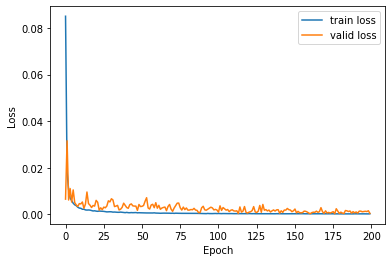

In [26]:
# loss
plt.plot(rnn.history['loss'], label='train loss')
plt.plot(rnn.history['val_loss'], label='valid loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(50, 250):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
RNN_predicted_stock_price = regressorRNN.predict(X_test)
RNN_predicted_stock_price = sc.inverse_transform(RNN_predicted_stock_price)

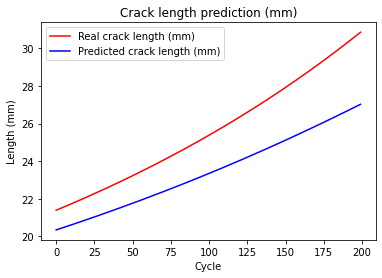

In [28]:
# Visualizing the results for RNN
plot_predictions(test_set, RNN_predicted_stock_price)

In [29]:
# Evaluating RNN
return_rmse(test_set, RNN_predicted_stock_price)

The root mean squared error is 2.3040671189324367.


**Compare predictions made by RNN, GRU, LSTM models by plotting data in a single graph**

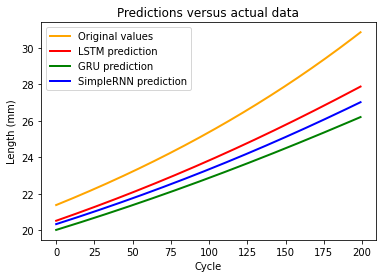

In [30]:
plt.figure(figsize=(6,4))

plt.plot(test_set, c="orange", linewidth=2, label="Original values")
plt.plot(LSTM_predicted_stock_price, c="red", linewidth=2, label="LSTM prediction")
plt.plot(GRU_predicted_stock_price, c="green", linewidth=2, label="GRU prediction")
plt.plot(RNN_predicted_stock_price, c="blue", linewidth=2, label="SimpleRNN prediction")
plt.legend()
plt.title("Predictions versus actual data", fontsize=12)
plt.xlabel('Cycle')
plt.ylabel('Length (mm)')
plt.show()

The end